# SPoOkY Meshes 👻

In [1]:
import time

import numpy as np
import scipy as sp
import meshplot as mp

import matplotlib.pyplot as plt

import scipy.sparse
import scipy.sparse.linalg
import meshio
import IPython

In [2]:
def load_mesh(filename):
    m = meshio.read(filename)
    v = m.points
    f = m.cells[0].data
    # center and scale mesh
    v = v - np.mean(v, axis=0)
    v = v / np.max(np.std(v, axis=0))
    return v, f


def save_mesh(filename, v, f):
    m  = meshio.Mesh(v, f)
    m.write(filename)


# v1, f1 = load_mesh('cw2_meshes/curvatures/plane.obj')
# v2, f2 = load_mesh('cw2_meshes/curvatures/lilium_s.obj')
# v3, f3 = load_mesh('cw2_meshes/decompose/armadillo.obj')
# v4, f4 = load_mesh('cw2_meshes/smoothing/fandisk_ns.obj')
# v5, f5 = load_mesh('cw2_meshes/smoothing/plane_ns.obj')
v7, f7 = load_mesh('sappho-hires.obj')
v8, f8 = load_mesh('gargoyle.off')

In [3]:
def standardize(v):
    """
    recenter points
    """
    v = v - np.mean(v, axis=0)
    v = v / np.std(v, axis=0).max()
    return v


def percentile_clip(h, n):
    """
    reject outlier points
    """
    return np.clip(h, np.percentile(h, n), np.percentile(h, 100 - n))

In [4]:
# Unsexy test mesh for debugging
v0 = np.array([
    [ 0, 0, 0],
    [-3, 4, 0],
    [-6, 0, 0],
    [-3,-4, 0],
    [ 3,-4, 0],
    [ 6, 0, 0],
    [ 3, 4, 0],
], dtype=np.float32)

f0 = np.array([
    [0, 1, 2],
    [0, 2, 3],
    [0, 3, 4],
    [0, 4, 5],
    [0, 5, 6],
    [0, 1, 6],
], dtype=np.int32)

# perturbed vertex indices to throw off naive algorithms
# f0 = np.array([
#     [1, 0, 2],
#     [2, 3, 0],
#     [0, 3, 4],
#     [4, 0, 5],
#     [5, 6, 0],
#     [6, 1, 0],
# ], dtype=np.int32)

## Laplace-Beltrami and Friends

### Vertex Area

In [322]:
def normalize(v):
    """
    normalize rows of vectors
    """
    return v / np.linalg.norm(v, axis=1)[:, np.newaxis]


def edges(f, n):
    """
    build an adjacency matrix, return edges in only one direction (upper triangular)
    """
    A = sp.sparse.triu(adjacency(f, n))
    ei, ej = A.nonzero()
    ed = np.vstack([ei, ej]).T
    # sort for consistency
    return np.sort(ed, axis=0)


def adjacency(f, n):
    """
    build a sparse adjacency matrix from faces in coordinate format.
    faces have some redundancy which we use a bitmask to filter.
    """
    A = sp.sparse.dok_matrix((n, n), dtype=bool)
    i, j, k = f.T
    A[i, j] = True
    A[j, k] = True
    A[k, i] = True
    A = A.tocsr()
    A = A + A.T
    return A


def face_normals(v, f):
    """
    compute normals of faces f
    """
    i, j, k = f.T
    # compute edges
    e1 = v[j] - v[i]
    e2 = v[k] - v[i]
    # cross product is face normal
    n = np.cross(e1, e2, axis=1)
    return normalize(n)


def triangle_area(v, f):
    """
    compute triangle areas
    """
    i, j, k = f.T
    a, b, c = v[i], v[j], v[k]

    ac = c - a
    bc = c - b

    return np.linalg.norm(np.cross(ac, bc, axis=1), axis=1) / 2


def vertex_area(v, f):
    """
    compute total area about vertices
    3.59ms for 281,724 faces, not bad son
    """
    n = len(v)
    A = np.zeros((3, len(f)))

    area = triangle_area(v, f)

    # set internal angles at vertex location in face array
    # using indexes that have duplicate values to increment doesn't work
    A[0] = area
    A[1] = area
    A[2] = area

    # some esoteric numpy for summing at duplicated indices
    # coo matrices are also an option
    data = A.ravel()
    cols = f.T.ravel()

    M = np.zeros(n)
    np.add.at(M, cols, data)

    return sp.sparse.diags(M)


def barycentric_mass(v, f):
    return vertex_area(v, f) / 3


M = barycentric_mass(v0, f0)
assert list(M.diagonal()) == [24, 8, 8, 8, 8, 8, 8]

assert len(edges(f0, len(v0))) == 12

# Cotangent operator

In [323]:
def cotangent_curvature(v, f):
    """
    we can sum the contribution of all adjacent angles,
    then subtract the contribution of all interior angles.
    
    using edges would probably avoid some redundant work here (as above).

    133ms seconds for 281,724 faces. igl is 52.2ms.
    """
    n = len(v)
    
    # indices
    i, j, k = f.T
    a, b, c = v[i], v[j], v[k]

    # vectors
    ab = b - a
    ac = c - a
    bc = c - b
    
    # big chungus cotangent computation
    abc = np.einsum('ij,ij->i', ab, ac) / np.linalg.norm(np.cross( ab, ac, axis=1), axis=1)
    bac = np.einsum('ij,ij->i',-ab, bc) / np.linalg.norm(np.cross(-ab, bc, axis=1), axis=1)
    cab = np.einsum('ij,ij->i',-ac,-bc) / np.linalg.norm(np.cross(-ac,-bc, axis=1), axis=1)

    # set weights for opposite edges
    # a csr_matrix will sum the quantities for us!
    data = np.hstack([cab, abc, bac])
    rows = np.hstack([i,   j,   k, ])
    cols = np.hstack([j,   k,   i, ])
    T = sp.sparse.csr_matrix((data, (rows, cols)))

    # mad gains by flipping across the diagonal ;)
    T = T + T.T

    # Nearly there. sum the rows and use as diagonal.
    S = sp.sparse.diags(T.sum(axis=1).A.ravel())
    T = T - S

    # i'm never doing this again
    # divide by two as we have computed k_1 + k_2
    return T / 2


# %timeit cotangent_curvature(v7, f7)

C = cotangent_curvature(v0, f0)
T = np.diag(np.round((180 / np.pi) * C.todense()))

assert list(T) == [-205, -73, -60, -73, -73, -60, -73]
assert np.sum(C) < 1e-6

### Check that mean curvature works

In [324]:
v, f = v8, f8

def mean_curvature_metric(v, f):
    M = barycentric_mass(v, f)
    C = cotangent_curvature(v, f)
    Mi = sp.sparse.diags(1 / M.diagonal())
    Hn = -Mi @ C @ v
    H  = np.linalg.norm(Hn, axis=1)
    return H


c = percentile_clip(mean_curvature_metric(v, f), 5)

mp.plot(v, f, c)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.212662…

### Compute Normals

In [373]:
def edge_triangle_adjacency(v, f):
    """
    appendix B.3: Edge based gradient
    build an |E| x |F| adjacency matrix where each row sums to 0
    ~280ms for ~280000 faces, mostly due to sorting
    """
    i, j, k = f.T
    # edges
    ed = np.hstack([
        [i, j],
        [j, k],
        [k, i],
    ])
    # test for jump discontinuity
    ix = np.argwhere(ed[0] < ed[1])
    # remove discontinuities
    ed.sort(axis=0)
    # rows are indices into unique edges
    ed, rows = np.unique(ed, axis=1, return_inverse=True)
    # columns are triangle indices
    cols = np.tile(np.arange(len(f)), 3)
    # use indices to mask duplicate values, s.t. all rows sum to 1 for a closed manifold
    data = 0 - np.ones(len(rows))
    data[ix] = 1
    # return edge-triangle adjacency matrix
    G = scipy.sparse.coo_matrix((data, (rows, cols)))
    # while we're in town, build edge lengths
    el = np.linalg.norm(v[ed[1]] - v[ed[0]], axis=1)
    return G, ed.T, el

# assert interior edges sum to 0, exterior edges sum to 1
G, ed, el = edge_triangle_adjacency(v0, f0)
Ti = scipy.sparse.diags(1 / triangle_area(v0, f0))

# the test mesh is not a closed manifold, so these results are weird
# but they are correct!
assert len(ed) == 12
assert np.allclose(G.sum(axis=0).A.ravel(), [1, 1, 1, 1, 1, 1])
assert np.allclose(G.sum(axis=1).A.ravel(), [2, 0, 0, 0, 0, -2, 1, 1, 1, 1, 1, 1])
assert np.allclose(el, [5, 6, 5, 5, 6, 5,5, 6, 5, 6, 5, 5])

In [374]:
def normest(A):
    """
    oli's attempt at normest in matlab
    square root of largest singular value of A?!?
    https://en.wikipedia.org/wiki/Matrix_norm
    """
    [e] = scipy.sparse.linalg.svds(A, k=1, return_singular_vectors=False)
    return e

G, ed, el = edge_triangle_adjacency(v0, f0)
assert np.abs(normest(G) - 2.2361) < 1e-4

In [451]:
def pdhg(prox_f, prox_g, G, D, u, q, gamma, sigma, tau, iters):
    i = 1
    err = float('inf')
    u_bar = u
    thresh = 1e-3
    
    u_prev = u
        
    for i in range(0, iters):
        if err < thresh:
            break
        
        # update primal and dual
        q = prox_f(q + sigma * G @ u_bar)

        u_prev = u
        u = prox_g(u + tau * D @ q, tau)
        u = u / np.linalg.norm(u, axis=1)[:, np.newaxis]

        theta = 1 / np.sqrt(1 + 2 * gamma * tau)
        tau = theta * tau
        sigma = sigma / theta
        
        u_bar = u + theta * (u - u_prev)
        u_bar = u_bar / np.linalg.norm(u_bar, axis=1)[:, np.newaxis]
        
        err = np.linalg.norm(u - u_prev)

    print(f"PDHG converged after {i} iterations, err: {err}, norm_u: {normest(u)}")
    return u, q
        

def decompose_normals(v, f, d, alpha, alpha_scale):
    """
    decomposeNormals: apply the spectral TV decomposition to a normal vector field f, defined on the triangles of the
    domain M, applying the algorithm 3 in the paper, where:
    - alpha is the maximum time of diffusion
    - nComp is the number fo spectral components to be computed
    - reductionParam is the scale parameter for alpha
    - nonuniform is a binary flag indicating whether alpha is scaled non-uniformily
    """
    # gradient operator and edge legnths
    G, ed, el = edge_triangle_adjacency(v, f)
    # divergence operator
    D = -G.T @ scipy.sparse.diags(el)
    # ???!?!
    pt = normest(G)
    # compute normal field
    n = face_normals(v, f)
    # primal is our normal field
    u = n
    # dual is a vector for each edge?!
    q = np.zeros((len(ed), 3))
    # output is our normal fields
    output = np.zeros((d, len(n), 3))
    # no idea what this is
    v = 0
    # or this
    g = 1
    # alpha is maximum diffusion time?!
    prev_alpha = alpha
    # iterations of pdhg
    iters = 1000
    
    def prox_f_star(x):
        # x./max(1,sqrt(sum((x.^2).*A,2)))
        y = np.sqrt(np.sum((x ** 2) * el[:, np.newaxis], axis=1))
        y[y < 1] = 1
        return x / y[:, np.newaxis]
    
    def prox_g(x, tau):
        # proxG= @(data,param)L2squaredProx(data, param/alpha, (f+v));
        # u = L2squaredProx(proxArgument, proxParam, f)
        # u = (proxArgument + proxParam*f)./(1 + proxParam);
        p = tau / alpha
        y = n + v
        return (x + p * y) / (1 + p)

    print(f"👻 👻 👻 Decomposing Mesh into {d} components 👻 👻 👻")
    for i in range(0, d):
        output[i] = u
        # run pdhg, 1000 iterations for each eigenvector
        u, q = pdhg(prox_f_star, prox_g, G, D, u, q, 1, 1 / pt, 1 / pt, iters)
        # scale alpha
        prev_alpha = alpha
        alpha = alpha * alpha_scale
        # ???
        v = (v + (n - u)) * alpha / prev_alpha
    return output

In [452]:
v, f = v8, f8
sub = decompose_normals(v, f, 40, 100, 0.8)

👻 👻 👻 Decomposing Mesh into 40 components 👻 👻 👻
PDHG converged after 999 iterations, err: 0.007071506478966335, norm_u: 124.57667312285942
PDHG converged after 999 iterations, err: 0.003920294287618377, norm_u: 127.18701977198413
PDHG converged after 999 iterations, err: 0.002484014322629627, norm_u: 128.7219638691689
PDHG converged after 999 iterations, err: 0.001559774092269252, norm_u: 129.52336058355255
PDHG converged after 958 iterations, err: 0.000997685455576804, norm_u: 129.65004348765115
PDHG converged after 999 iterations, err: 0.0016022399200733908, norm_u: 128.89267687582588
PDHG converged after 999 iterations, err: 0.0031153683971562826, norm_u: 126.80242759601153
PDHG converged after 999 iterations, err: 0.004224985868295879, norm_u: 123.4958775006758
PDHG converged after 999 iterations, err: 0.003875818841733421, norm_u: 120.4897616725781
PDHG converged after 999 iterations, err: 0.0025214735871068776, norm_u: 119.01152645335938
PDHG converged after 999 iterations, err: 

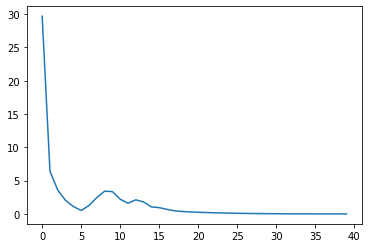

In [453]:
# compute and plot the TV spectrum

phi = sub.copy()
for i in range(1, len(phi)):
    phi[i] = phi[i] - sub[i - 1]

A = triangle_area(v, f)
S = np.sum(np.abs(A * np.linalg.norm(phi, axis=2)), axis=1)

plt.plot(S)
plt.show()

## TV Divergence & Gradient Operators

hack this together

$$
\mathbf{G} f\left(\mathbf{t}_{i j k}\right)=\left(\begin{array}{cc}
\mathbf{v}_{j}^{\top}-\mathbf{v}_{i}^{\top} \\
\mathbf{v}_{k}^{\top}-\mathbf{v}_{i}^{\top}
\end{array}\right)^{\top}\left(\begin{array}{cc}
\left\|e_{i j}\right\|^{2} & \left\langle e_{i j}, e_{i k}\right\rangle \\
\left\langle e_{i j}, e_{i k}\right\rangle & \left\|e_{i k}\right\|^{2}
\end{array}\right)\left(\begin{array}{l}
f\left(\mathbf{v}_{j}\right)-f\left(\mathbf{v}_{i}\right) \\
f\left(\mathbf{v}_{k}\right)-f\left(\mathbf{v}_{i}\right)
\end{array}\right)
$$

In [158]:
def tv_gradient_operator(v, f, axis):
    # indices
    i, j, k = f.T

    # edges?
    e_ij = v[j] - v[i]
    e_ik = v[k] - v[i]
    
    # hstack and reshape into F x 2 x 3
    # TODO: can we remove this swapaxes?
    A = np.hstack([
        e_ij,
        e_ik,
    ]).reshape(len(f), 2, 3).swapaxes(1, 2)
    
    e_ij2 = np.sum(e_ij ** 2, axis=1)
    e_ik2 = np.sum(e_ik ** 2, axis=1)
    
    e_min = np.min(np.hstack([np.sqrt(e_ij2), np.sqrt(e_ik2)]))

    e_ijik = np.einsum('ij,ij->i', e_ij, e_ik)

    B = np.hstack([
        [e_ij2, e_ijik, e_ijik, e_ik2],             
    ]).reshape(2, 2, len(f)).T

    # our 'function' is the X coordinate for now
    C = np.array([
        v[j][:, axis] - v[i][:, axis],
        v[k][:, axis] - v[i][:, axis],
    ]).reshape(len(f), 2, 1)

    D = A @ B @ C
    
    rows = np.repeat(np.arange(0, len(f)), 3)
    cols = f.ravel()
    data = D.ravel()

    G = sp.sparse.csr_matrix((data, (rows, cols)))
    
    # compute tau, sigma while we're in toon
    N = twonormest(G)
    t = e_min / N
    
    return G, t


def tv_gradient_operators(v, f, axis=0):
    """
    return G and adjoint D
    """
    G, t = tv_gradient_operator(v, f, axis)
    A = barycentric_mass(v, f)
    T = sp.sparse.diags(triangle_area(v, f))
    Ai = sp.sparse.diags(1 / A.diagonal())
    D = -Ai @ G.T @ T
    return G, D, t


# Test that our unsexy mesh produces the correct value for the first row
G, t = tv_gradient_operator(v0, f0)
assert np.allclose(G.todense().A[0], [2169, -732, 0, 0, 0, 0, 0])

# test that we get a value for tau / sigma
assert np.allclose(t, 0.083425544)

In [377]:
v, f = v7, f7

# todo: standardize v?
u0 = face_normals(v, f)

sub, phi = decompose_normals(v, f, u0, alpha, 40, nonuniform=False, g=1)


In [348]:
def prox_f(q):
    """
    Equation (16)
    Projects q onto the l2 ball
    """
    qT = q.T
    qT_norm = np.linalg.norm(qT, axis=0)
    indices = qT_norm > 1
    qT[:, indices] = qT[:, indices] / qT_norm[indices]
    return qT.T

A = np.array([
    [0  ,   1,   2],  # normalized
    [1/2, 1/2, 1/2],  # unchanged
    [1/3, 1/3, 1/3],  # unchanged
    [1/4, 1/4, 1/4],  # unchanged
])
proj = prox_f(A)

assert np.allclose(proj[0], [0. , 0.4472136 , 0.89442719])
assert np.allclose(proj[1], A[1])
assert np.allclose(proj[2], A[2])
assert np.allclose(proj[3], A[3])

In [349]:
def prox_g(u, u_0, tau, alpha):
    """
    Equation (17)
    ???
    """
    return (u + (tau / alpha) * u_0) / (1 + (tau / alpha))

In [364]:
def pdhg(v, f, u, u_0, q, alpha, axis=0):
    # algorithm 2
    G, D, tau = tv_gradient_operators(v, f, axis)
    sigma = tau
    theta = 0.5
    
    while True:
        u_next = prox_g(u - tau * D @ q, u_0, tau, alpha)
        u_bar  = u_next + theta * (u_next - u)
        q_next = prox_f(q + sigma * G @ u_bar)
        
        print(np.linalg.norm(u_next - u))
        if np.linalg.norm(u_next - u) < 1e-6:
            break

        u = u_next
        q = q_next
    return u

In [369]:
def solve(v, f, axis):
    """
    The algorithm simply evolves the input signal by N discrete steps along the TV flow;
    each iteration moves a step forward, with diffusion time equal to α.
    As changes happen quickly for small t and tend to become slower for larger t
    we iteratively increase the step size α of the evolution.
    
    Subsequently, the spectral representation φt is constructed incrementally using finite differences,
    such that the integral of Eq. (12) becomes a simple weighted sum over the φt.
    We give selection strategies for α and N in Appendix B.4.
    """
    n = 5  # number of time steps ~= number of features?!
    
    u_0 = v[:, axis]  # input signal
    u_t = np.zeros((n, *u_0.shape))  # feature stack
    p_t = np.zeros_like(u_t)  # spectral representation

    alpha = 1e-9  # step size - not sure what this should be
    
    # initialize u
    u = u_0
    
    # initialize q
    q = np.zeros_like(f[:, axis])

    for t in range(0, n):
        u_t[t] = pdhg(v, f, u, u_0, q, alpha, axis=0)
        p_t[t] = u_t[t] - u_t[t-1]  # 0 on first run?
        alpha  = alpha + alpha * 0.1
        u_0    = u_t[t]
    return p_t


p_t = solve(v7, f7, axis=0)

v7_t = np.vstack([p_t[0], v7[:, 1], v7[:, 2]]).T

print(v7_t)

mp.plot(v7_t, f7)

1.0948308170645484e-12
1.0822538358357315e-12
1.040196331096403e-12
9.876057739526858e-13
9.903753955288679e-13
[[ 23.082001  96.296005 -18.754002]
 [ 23.042002  96.040001 -18.974001]
 [ 23.162001  96.074005 -18.496   ]
 ...
 [ 24.982     78.830002 -16.602001]
 [ 55.364002  92.348007  -6.774   ]
 [ 55.476002  92.530006  -6.914001]]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(28.620000…